In [1]:
import requests
import time

import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import re
import glob
import random
import seaborn as sns
import string

from IPython.display import clear_output

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# http://www.nltk.org/howto/wordnet.html

from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.wsd import lesk

In [2]:
# Location of test/train data files on local computer, data downloaded directly from Stanford source[2]
#test_dir = '/Users/philiposborne/Documents/Written Notes/Learning Notes/IMDB Reviews/IMDB Data/test'
#train_dir = '/Users/philiposborne/Documents/Written Notes/Learning Notes/IMDB Reviews/IMDB Data/train'

data = pd.read_csv("/Users/wofeishenling/python_note/Python_Road/pytorch/imdb_master.csv")
print(data.columns)


Index(['Unnamed: 0', 'id', 'type', 'rating', 'pol', 'text'], dtype='object')


In [3]:
# Select only training data
data = data[data['type']=='train'].reset_index(drop=True)
print(data.columns)

Index(['Unnamed: 0', 'id', 'type', 'rating', 'pol', 'text'], dtype='object')


In [4]:
print('Number of comments in data:', len(data))

data = data[0:1000]

print('Number of comments left in data after removal:', len(data))

Number of comments in data: 25000
Number of comments left in data after removal: 1000


In [5]:
train_data = data

In [6]:
# Data import written as a function:
# Replace test and train dir with correct path for file saved on local computer
# Data files are downloaded from reference link above where main file name is changed to IMDB Data

# This function converts the raw files form the original Stanford source into csv files.
"""
def IMDB_to_csv(directory):    
    data = pd.DataFrame()
    
    for filename in glob.glob(str(directory)+'/neg/*.txt'):
        with open(filename, 'r',  encoding="utf8") as f:
            content = f.readlines()
            content_table = pd.DataFrame({'id':filename.split('_')[0].split('/')[-1],'rating':filename.split('_')[1].split('.')[0],'pol':'neg', 'text':content})
        data = data.append(content_table)
        
    for filename in glob.glob(str(directory)+'/pos/*.txt'):
        with open(filename, 'r',  encoding="utf8") as f:
            content = f.readlines()
            content_table = pd.DataFrame({'id':filename.split('_')[0].split('/')[-1],'rating':filename.split('_')[1].split('.')[0],'pol':'pos', 'text':content})
        data = data.append(content_table)
    data = data.sort_values(['pol','id'])
    data = data.reset_index(drop=True)
    #data['rating_norm'] = (data['rating'] - data['rating'].min())/( data['rating'].max() - data['rating'].min() )

    return(data)

train_data = IMDB_to_csv(train_dir)
"""

'\ndef IMDB_to_csv(directory):    \n    data = pd.DataFrame()\n    \n    for filename in glob.glob(str(directory)+\'/neg/*.txt\'):\n        with open(filename, \'r\',  encoding="utf8") as f:\n            content = f.readlines()\n            content_table = pd.DataFrame({\'id\':filename.split(\'_\')[0].split(\'/\')[-1],\'rating\':filename.split(\'_\')[1].split(\'.\')[0],\'pol\':\'neg\', \'text\':content})\n        data = data.append(content_table)\n        \n    for filename in glob.glob(str(directory)+\'/pos/*.txt\'):\n        with open(filename, \'r\',  encoding="utf8") as f:\n            content = f.readlines()\n            content_table = pd.DataFrame({\'id\':filename.split(\'_\')[0].split(\'/\')[-1],\'rating\':filename.split(\'_\')[1].split(\'.\')[0],\'pol\':\'pos\', \'text\':content})\n        data = data.append(content_table)\n    data = data.sort_values([\'pol\',\'id\'])\n    data = data.reset_index(drop=True)\n    #data[\'rating_norm\'] = (data[\'rating\'] - data[\'rating\'].mi

In [7]:
print(train_data.columns)
train_data.columns = ['id-', 'id', 'dataset', 'rating', 'pol', 'text']
train_data.head()

Index(['Unnamed: 0', 'id', 'type', 'rating', 'pol', 'text'], dtype='object')


,id-,id,dataset,rating,pol,text
0,0,0,train,3,neg,Story of a man who has unnatural feelings for ...
1,1,1,train,1,neg,Robert DeNiro plays the most unbelievably inte...
2,2,10,train,2,neg,"This film had a lot of promise, and the plot w..."
3,3,100,train,3,neg,OK its not the best film I've ever seen but at...
4,4,1000,train,4,neg,"The plot for Descent, if it actually can be ca..."


In [8]:
train_data['text'][0].split('.')

['Story of a man who has unnatural feelings for a pig',
 ' Starts out with a opening scene that is a terrific example of absurd comedy',
 " A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers",
 ' Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting',
 ' Even those from the era should be turned off',
 ' The cryptic dialogue would make Shakespeare seem easy to a third grader',
 " On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond",
 ' Future stars Sally Kirkland and Frederic Forrest can be seen briefly',
 '']

In [9]:
train_data['text'][0].split('.')[0]

'Story of a man who has unnatural feelings for a pig'

In [10]:
len(train_data['text'][0].split('.'))

9

In [11]:
train_data['text'][0].split('.')[8]

''

In [12]:
train_data_sent = pd.DataFrame()

start_time = time.time()
for index in train_data.index:
    data_row = train_data.iloc[index,:]

    for sent_id in range(0,len(data_row['text'].split('.'))-1):
        sentence = data_row['text'].split('.')[sent_id]
        # Form a row in a dataframe for this setence that captures the words and keeps ids and polarity scores
        # We must pass an arbitrary index which we then reset to show unique numbers
        sentence_row = pd.DataFrame({
                                     'id':data_row['id'],
                                     'pol':data_row['pol'],
                                     'sent_id':sent_id,
                                     'sentence':sentence}, index = [index]) 
        
        # Form full table that has rows for all sentences
        train_data_sent = train_data_sent.append(sentence_row)
    
    
    # Outputs progress of main loop, see:
    clear_output(wait=True)
    print('Proportion of comments completed:', np.round(index/len(train_data),4)*100,'%')
    
end_time = time.time()
print('Total run time = ', np.round(end_time-start_time,2)/60, ' minutes')
# Reset index so that each index value is a unique number
train_data_sent = train_data_sent.reset_index(drop=True)

Proportion of comments completed: 99.9 %
Total run time =  0.5521666666666667  minutes


In [13]:
train_data_sent.head()

,id,pol,sent_id,sentence
0,0,neg,0,Story of a man who has unnatural feelings for ...
1,0,neg,1,Starts out with a opening scene that is a ter...
2,0,neg,2,A formal orchestra audience is turned into an...
3,0,neg,3,Unfortunately it stays absurd the WHOLE time ...
4,0,neg,4,Even those from the era should be turned off


In [14]:
train_data_sent['sentence_clean'] = train_data_sent['sentence'].str.replace('[{}]'.format(string.punctuation), '')
train_data_sent['sentence_clean'] = train_data_sent['sentence_clean'].str.lower()

train_data_sent['sentence_clean'] = '<s ' + train_data_sent['sentence_clean']
train_data_sent['sentence_clean'] = train_data_sent['sentence_clean'] + ' /s>'

train_data_sent.head()

,id,pol,sent_id,sentence,sentence_clean
0,0,neg,0,Story of a man who has unnatural feelings for ...,<s story of a man who has unnatural feelings f...
1,0,neg,1,Starts out with a opening scene that is a ter...,<s starts out with a opening scene that is a ...
2,0,neg,2,A formal orchestra audience is turned into an...,<s a formal orchestra audience is turned into...
3,0,neg,3,Unfortunately it stays absurd the WHOLE time ...,<s unfortunately it stays absurd the whole ti...
4,0,neg,4,Even those from the era should be turned off,<s even those from the era should be turned o...


In [15]:
text = train_data_sent['sentence_clean']
text_list = " ".join(map(str, text))
text_list[0:100]

'<s story of a man who has unnatural feelings for a pig /s> <s  starts out with a opening scene that '

In [16]:
word_list = pd.DataFrame({'words':text.str.split(' ', expand = True).stack().unique()})

In [17]:
word_count_table = pd.DataFrame()
for n,word in enumerate(word_list['words']):
    # Create a list of just the word we are interested in, we use regular expressions so that part of words do not count
    # e.g. 'ear' would be counted in each appearance of the word 'year'
    word_count = len(re.findall(' ' + word + ' ', text_list))  
    word_count_table = word_count_table.append(pd.DataFrame({'count':word_count}, index=[n]))
    
    clear_output(wait=True)
    print('Proportion of words completed:', np.round(n/len(word_list),4)*100,'%')

word_list['count'] = word_count_table['count']
# Remove the count for the start and end of sentence notation so 
# that these do not inflate the other probabilities
word_list['count'] = np.where(word_list['words'] == '<s' , 0,
                     np.where(word_list['words'] == '/s>', 0,
                     word_list['count']))

Proportion of words completed: 99.99 %


In [31]:
word_list['prob'] = word_list['count']/sum(word_list['count'])
sorted_word_list = word_list.sort_values(ascending=False ,by='prob');
sorted_word_list.head(20)

,words,count,prob
34,the,12297,0.054378
12,,11032,0.048784
3,a,5911,0.026139
87,and,5350,0.023658
2,of,5156,0.022800
66,to,5152,0.022782
19,is,3738,0.016530
124,in,3223,0.014252
177,i,3219,0.014235
101,this,3043,0.013456


In [33]:
unigram_table = pd.DataFrame()

start_time = time.time()
# Loop through each sentence
# REMOVE ROW LIMIT FOR FULL RUN
for index in train_data_sent[0:200].index:#get top 200
    data_row = train_data_sent.iloc[index,:]

    sent_probs = pd.DataFrame()
    # Go through each word in the sentence, lookup the probability of the word and 
    # then find the mulitplicitive product of all probabilities in the sentence.
    for n,word in enumerate(data_row['sentence_clean'].split(' ')):
        sent_probs = sent_probs.append(pd.DataFrame({'prob':word_list[ word_list['words']==word]['prob']}, index = [n]))
    unigram = sent_probs['prob'].prod(axis=0)
    
    # Create a list of unigram calculation for each sentence
    unigram_table = unigram_table.append(pd.DataFrame({'unigram':unigram},index = [index]))
    
    clear_output(wait=True)
    print('Proportion of sentences completed:', np.round(index/len(train_data_sent),4)*100,'%')
        
end_time = time.time()
print('Total run time = ', np.round(end_time-start_time,2)/60, ' minutes')

train_data_sent['unigram'] = unigram_table['unigram']

Proportion of sentences completed: 1.49 %
Total run time =  2.280333333333333  minutes


In [34]:
unigram_table.head(50)

,unigram
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


In [ ]:
unigram_table_log = pd.DataFrame()

start_time_log = time.time()
# Loop through each sentence
# REMOVE ROW LIMIT FOR FULL RUN
for index in train_data_sent[0:200].index:
    data_row = train_data_sent.iloc[index,:]

    sent_probs = pd.DataFrame()
    # Go through each word in the sentence, lookup the probability of the word and 
    # then find the mulitplicitive product of all probabilities in the sentence.
    for n,word in enumerate(data_row['sentence_clean']):
        log_prob = np.log10(word_list[ word_list['words']==word]['prob'])
        sent_probs = sent_probs.append(pd.DataFrame({'log_prob':log_prob}, index = [n]))
        
    unigram_log = sum(sent_probs['log_prob'])
    
    # Create a list of unigram calculation for each sentence
    unigram_table_log = unigram_table.append(pd.DataFrame({'unigram_log':unigram_log},index = [index]))
                                         
    clear_output(wait=True)
    print('Proportion of sentences completed:', np.round(index/len(train_data_sent),4)*100,'%')
                                                                   
end_time_log = time.time()
print('Total run time = ', np.round(end_time_log-start_time_log,2)/60, ' minutes')

#train_data_sent['unigram_log'] = unigram_table_log['unigram_log']

In [ ]:
word_1 = 'to'
word_2 = 'a'

prob_word_1 = word_list[word_list['words'] == word_1]['prob'].iloc[0]
prob_word_2 = word_list[word_list['words'] == word_2]['prob'].iloc[0]

unigram_prob = prob_word_1*prob_word_2

print('The unigram probability of the word "a" occuring given the word "to" was the previous word is: ', np.round(unigram_prob,10))

In [19]:
word_1 = ' ' + str('to') + ' '
word_2 = str('a') + ' '

bigram_prob = len(re.findall(word_1 + word_2, text_list)) / len(re.findall(word_1, text_list)) 

print('The probability of the word "a" occuring given the word "to" was the previous word is: ', np.round(bigram_prob,5))

The probability of the word "a" occuring given the word "to" was the previous word is:  0.02232


In [23]:
W_W_Matrix = pd.DataFrame({'words': word_list['words']})

start_time = time.time()


# Add limits to number of columns/rows so this doesn't run for ages
column_lim = 1000
#column_lim = len(W_W_Matrix)
row_lim = 10
#row_lim = len(W_W_Matrix)

for r, column in enumerate(W_W_Matrix['words'][0:column_lim]):
    
    prob_table = pd.DataFrame()
    for i, row in enumerate(W_W_Matrix['words'][0:row_lim]):

        word_1 = ' ' + str(row) + ' '
        word_2 = str(column) + ' '

        if len(re.findall(word_1, text_list)) == 0:
            prob = pd.DataFrame({'prob':[0]}, index=[i])
        else:
            prob = pd.DataFrame({'prob':[len(re.findall(word_1 + word_2, text_list)) / len(re.findall(word_1, text_list)) ]}, index=[i])
        
        prob_table = prob_table.append(prob)
    W_W_Matrix[str(column)] = prob_table['prob']
    
    # Outputs progress of main loop, see:
    clear_output(wait=True)
    print('Proportion of column words completed:', np.round(r/len(W_W_Matrix[0:column_lim]),2)*100,'%')
    
end_time = time.time()
print('Total run time = ', np.round(end_time-start_time,2)/60, ' minutes')

Proportion of column words completed: 100.0 %
Total run time =  1.9873333333333332  minutes


In [27]:
W_W_Matrix.head(10)

,words,<s,story,of,a,man,who,has,unnatural,feelings,...,melodrama,tricked,existential,angst,comes,shopworn,visualaural,tricks,deafening,scratching
0,<s,0.0,0.000000,0.000150,0.002775,0.000075,0.000300,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,story,0.0,0.000000,0.050761,0.005076,0.000000,0.000000,0.017766,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,of,0.0,0.000388,0.000194,0.049457,0.000000,0.000776,0.000000,0.000000,0.0,...,0.0,0.0,0.000194,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,a,0.0,0.004060,0.000000,0.000169,0.003553,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,man,0.0,0.000000,0.000000,0.000000,0.000000,0.122137,0.007634,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.007634,0.0,0.0,0.0,0.0,0.0
5,who,0.0,0.000000,0.000000,0.001387,0.000000,0.000000,0.040222,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.006935,0.0,0.0,0.0,0.0,0.0
6,has,0.0,0.000000,0.000000,0.134100,0.000000,0.000000,0.000000,0.001916,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
7,unnatural,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
8,feelings,0.0,0.000000,0.222222,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9,for,0.0,0.000000,0.000000,0.097407,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


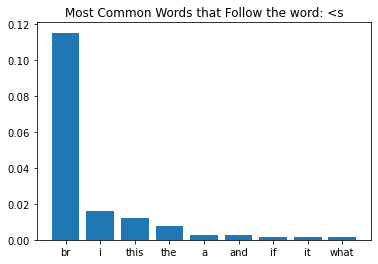

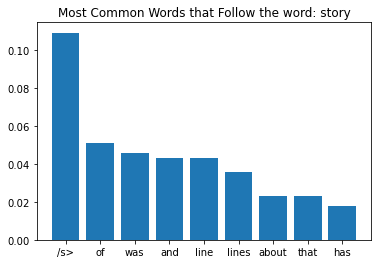

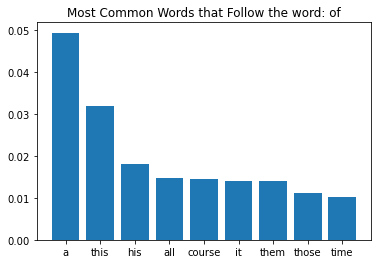

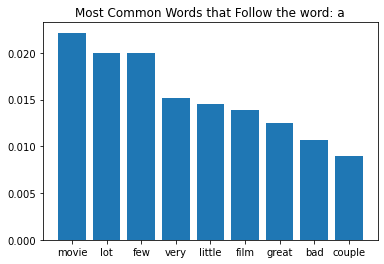

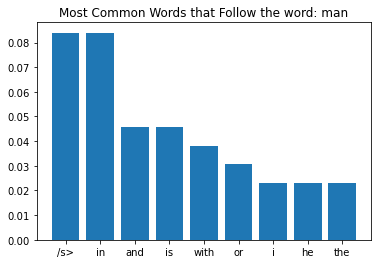

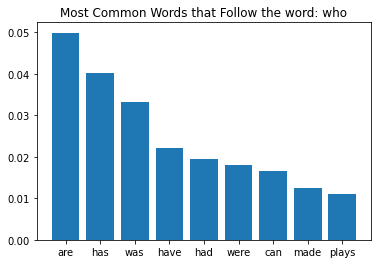

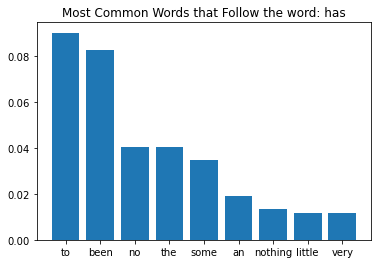

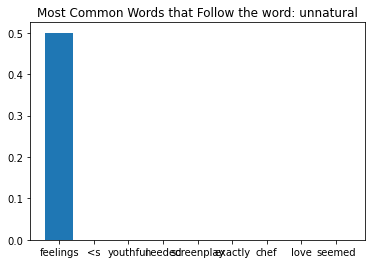

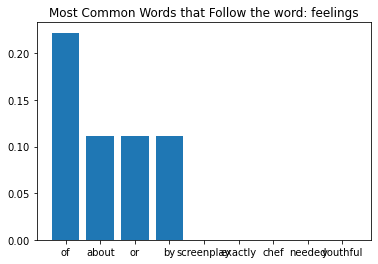

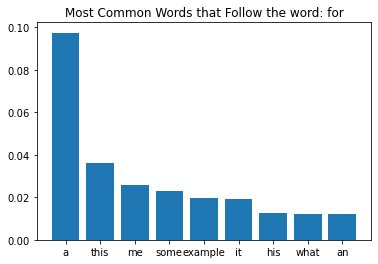

In [28]:
for i in range(0,row_lim):
    plt.bar(W_W_Matrix.iloc[i,1:].sort_values(ascending=False)[1:10].index,W_W_Matrix.iloc[i,1:].sort_values(ascending=False)[1:10].values)
    plt.title('Most Common Words that Follow the word: ' +str(W_W_Matrix.iloc[i,0]))
    plt.show()